# <font color='DarkBlue'> Residual Networks

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation,  AveragePooling2D, MaxPooling2D
from keras.layers import ZeroPadding2D, BatchNormalization,Flatten,Conv2D,GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K

K.set_image_data_format('channels_last')
K.set_learning_phase(1)
%matplotlib inline

Using TensorFlow backend.


## <font color='IndianRed'> Problem with very deep NNs

In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that *it can represent very complex functions*. It can also learn features at many different levels of abstraction i.e. from edges (at the shallow layers, closer to the input) to very complex features (at the deeper layers, closer to the output).

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

* More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds

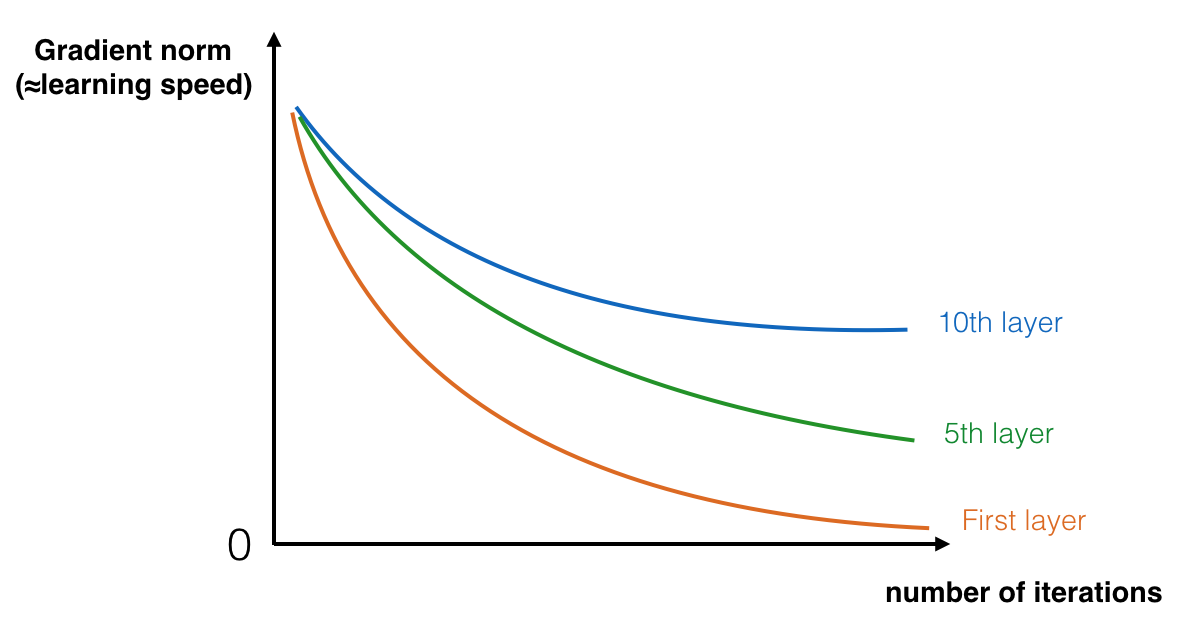

In [2]:
Image(filename="images/vanishing_grad.png", width=500, height=750)

The speed of learning decreases very rapidly for the shallower layers as the network trains. This is the problem solved by Residual Networks.

## <font color='IndianRed'>Building a Residual Network

In ResNets, a *shortcut* or a *skip connection* allows the signal to skip layers (as part of propagating the identity function explained in theory)  

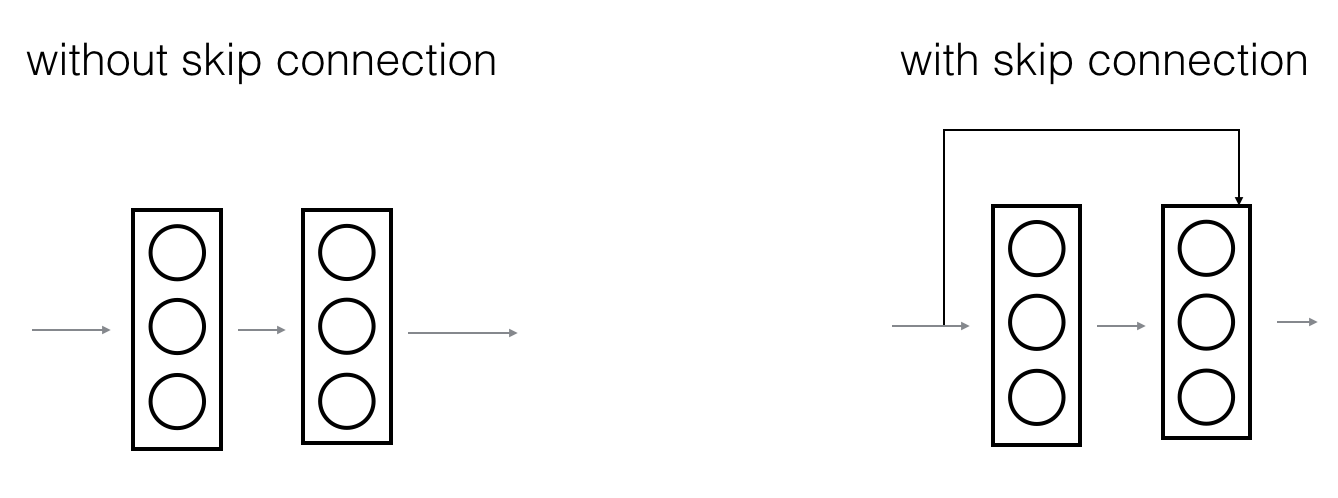

In [3]:
Image(filename="images/skip_connection.png", width=600, height=800)

The image on the left shows the *main path* through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

Having ResNet blocks with the shortcut makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.
Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. We are going to implement both of them: the *identity block* and the *convolutional block*

### <font color='Indigo'>Identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$).

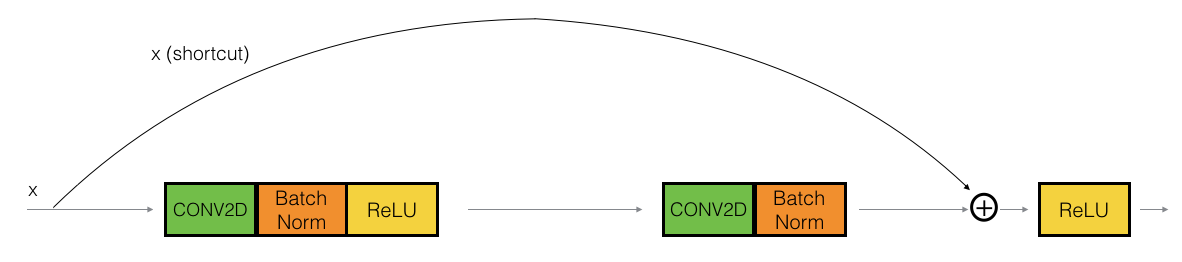

In [4]:
Image(filename="images/idblock.png", width=600, height=800)

The upper path is the *shortcut*. The lower path is the _main_ path. In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step. In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection skips over 3 hidden layers rather than 2 layers. 

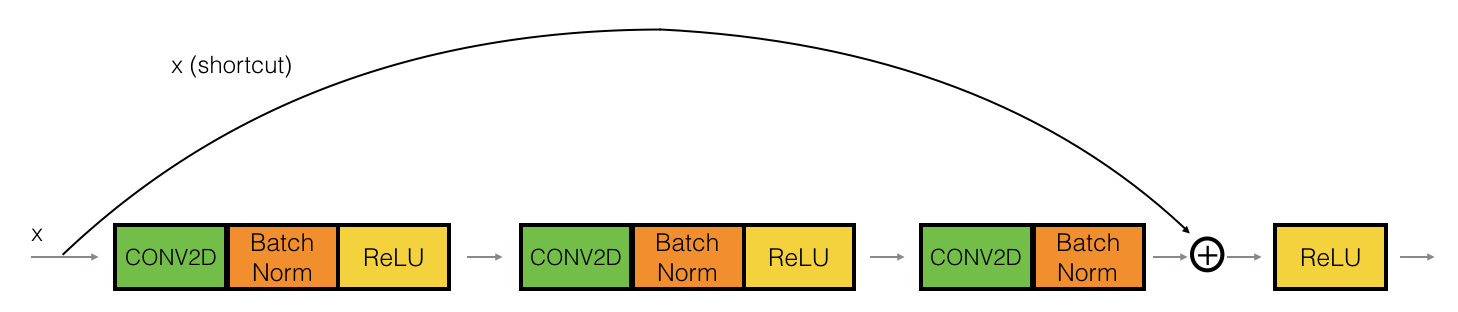

In [5]:
Image(filename="images/idblock_mod.png", width=600, height=800)

**First component - main path**: 
- The first `CONV2D` has $F_1$ filters of shape `(1,1)` and a stride of `(1,1)`. Its padding is `valid` and its name should be `conv_name_base + '2a'`. 
- The first `BatchNorm` is normalizing the `channels` axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the `ReLU` activation function.

**Second component - main path**:
- The second `CONV2D` has $F_2$ filters of shape $(f,f)$ and a stride of `(1,1)`. Its padding is `same` and its name should be `conv_name_base + '2b'`.  
- The second `BatchNorm` is normalizing the `channels` axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the `ReLU` activation function. 

**Third component - main path**:
- The third `CONV2D` has $F_3$ filters of shape `(1,1)` and a stride of `(1,1)`. Its padding is `valid` and its name should be `conv_name_base + '2c'`.  
- The third `BatchNorm` is normalizing the `channels` axis.  Its name should be `bn_name_base + '2c'`. 
- Note that there is no `ReLU` activation function in this component. 

**Final step**: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- The syntax will look something like `Add()([var1,var2])`
- Then apply the `ReLU` activation function. 

In [6]:
# ResNet Identity block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X      -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f      -- integer, specifying the shape of the middle CONV's window for the main path
    filter -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage  -- integer, used to name the layers, depending on their position in the network
    block  -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters      # retrieve filters
    X_shortcut = X            # cache X for shortcut
    
    # First component of main path
    X = Conv2D(filters = F1, 
               kernel_size = (1, 1), 
               strides = (1,1), 
               padding = 'valid', 
               name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, 
               kernel_size = (f, f), 
               strides = (1, 1), 
               padding='same', 
               name = conv_name_base + '2b', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, 
               kernel_size=(1, 1), 
               strides=(1, 1), 
               padding='valid', 
               name=conv_name_base + '2c', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [7]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.94822985  0.          1.16101444  2.747859    0.          1.36677003]


## <font color='Indigo'>The Convolutional block

The ResNet Convolutional block is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in 
the shortcut path

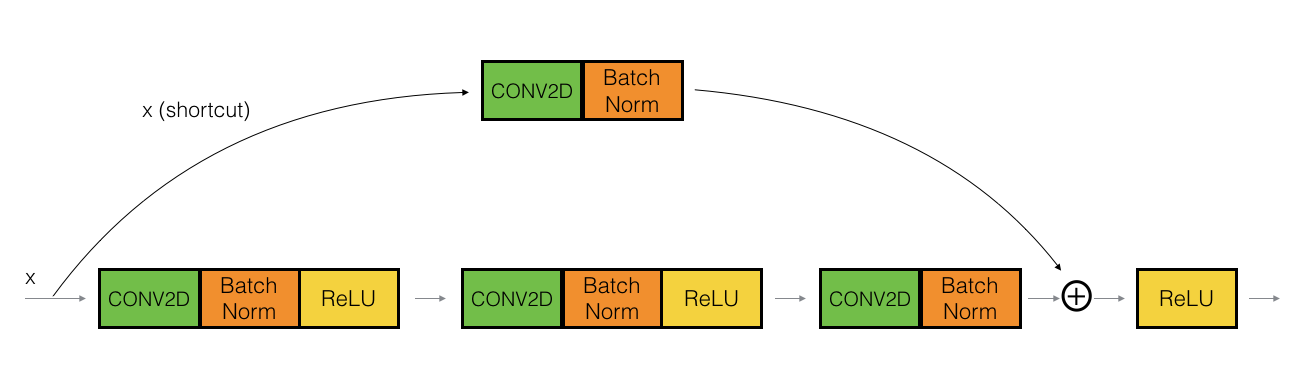

In [8]:
Image(filename='images/convblock.png', height=800, width=600)

* The `CONV2D` layer in the shortcut path is used to resize the input $X$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a `1x1` convolution with a stride of 2.

* The `CONV2D` layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 


**First component - main path**:
- The first `CONV2D` has $F_1$ filters of shape `(1,1)` and a stride of `(s,s)`. Its padding is `valid` and its name should be `conv_name_base + '2a'`.
- The first `BatchNorm` is normalizing the _channels_ axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the `ReLU` activation function. 

**Second component - main path**
- The second `CONV2D` has $F_2$ filters of shape `(f,f)` and a stride of `(1,1)`. Its padding is `same` and it's name should be `conv_name_base + '2b'`.  
- The second `BatchNorm` is normalizing the _channels_ axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the `ReLU` activation function. 

**Third component - main path**
- The third `CONV2D` has $F_3$ filters of shape `(1,1)` and a stride of `(1,1)`. Its padding is `valid` and it's name should be `conv_name_base + '2c'`.  
- The third `BatchNorm` is normalizing the _channels_ axis.  Its name should be `bn_name_base + '2c'`. Note that there is no `ReLU` activation function in this component. 

**Shortcut**:
- The `CONV2D` has $F_3$ filters of shape `(1,1)` and a stride of `(s,s)`. Its padding is `valid` and its name should be `conv_name_base + '1'`. 
- The `BatchNorm` is normalizing the _channels_ axis.  Its name should be `bn_name_base + '1'`. 

**Final step** 
- The shortcut and the main path values are added together.
- Apply the `ReLU` activation function.

In [9]:
# ResNet convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X        -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f        -- integer, specifying the shape of the middle CONV's window for the main path
    filters  -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage    -- integer, used to name the layers, depending on their position in the network
    block    -- string/character, used to name the layers, depending on their position in the network
    s        -- Integer, specifying the stride to be used
    
    Returns:
    X        -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters          # Retrieve Filters
    X_shortcut = X                # save X for shortcut


    #### MAIN PATH ####
    # First component of main path 
    X = Conv2D(filters = F1,
               kernel_size = (1, 1), 
               strides = (s,s), 
               padding = 'valid',
               name = conv_name_base + '2a',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, 
                           name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path
    X = Conv2D(filters = F2, 
               kernel_size = (f,f), 
               strides = (1,1),
               padding = 'same',
               name = conv_name_base + '2b', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, 
                           name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, 
               kernel_size=(1,1), 
               strides = (1,1), 
               padding = 'valid', 
               name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, 
                           name = bn_name_base + '2c')(X)

    ### SHORTCUT ###
    X_shortcut = Conv2D(filters = F3, 
                        kernel_size = (1, 1), 
                        strides = (s, s), 
                        padding = 'valid', 
                        name = conv_name_base + '1', 
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, 
                                    name = bn_name_base + '1')(X_shortcut)
    
    #### Final addition ####
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [ 0.09018463  1.23489773  0.46822017  0.0367176   0.          0.65516603]


## <font color='IndianRed'>Building your ResNet-50

The following figure describes in detail the architecture of this neural network. `ID BLOCK` implies _Identity block_, and `ID BLOCK x3` means you should stack 3 identity blocks together.

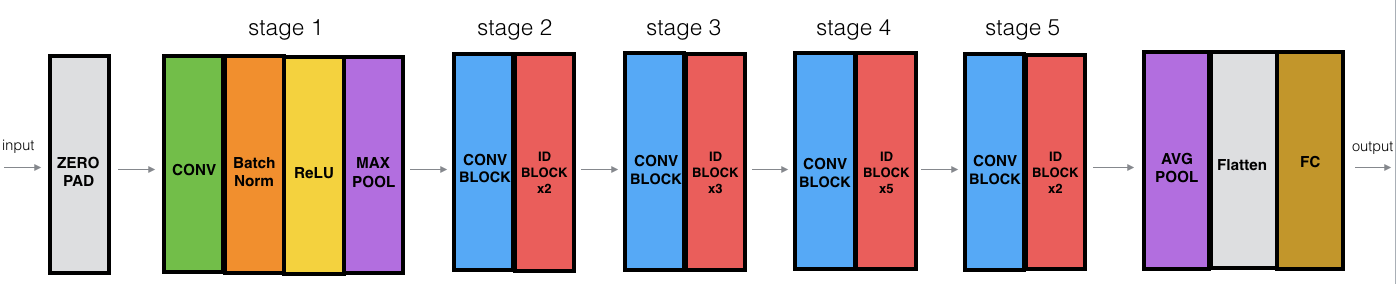

In [11]:
Image(filename='images/resnet50.png')

The details of this ResNet-50 model are:

- Zero-padding pads the input with a pad of `(3,3)`
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride = (2,2). Its name is `conv1`.
    - BatchNorm is applied to the _channels_ axis of the input.
    - MaxPooling uses a `(3,3)` window and a stride = `(2,2)`.
- Stage 2:
    - The convolutional block uses three sets of filters of size `[64,64,256]` 
    - `f` = 3, `s` = 1 and the block is _a_.
    - The 2 identity blocks use 3 sets of filters of size `[64,64,256]`, `f` = 3, blocks are _b, c_
- Stage 3:
    - The convolutional block uses 3 sets of filters of size `[128,128,512]`, `f`=3, `s` = 2 & block is _a_
    - The 3 identity blocks use 3 sets of filters of size `[128,128,512]`, `f`= 3 and the blocks are _b,c,d_.
- Stage 4:
    - The convolutional block uses 3 sets of filters of size `[256, 256, 1024]`, `f`= 3, `s`= 2 and block is _a_.
    - The 5 identity blocks use 3 sets of filters of size `[256, 256, 1024]`, `f`= 3 and blocks are _b,c,d,e,f_.
- Stage 5:
    - The convolutional block uses 3 sets of filters of size `[512, 512, 2048]`, `f` = 3,`s` = 2 and block is _a_.
    - The 2 identity blocks use 3 sets of filters of size `[512, 512, 2048]`, `f` = 3 and blocks are _b,c_ 
    
- The 2D Average Pooling uses a window of shape (2,2) and its name is `avg_pool`.
- The `flatten` layer doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

In [12]:
#ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes     -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), 
               strides = (2, 2), 
               name = 'conv1', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, 
                           name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), 
                     strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

   
    # Stage 3
    X = convolutional_block(X, f = 3, filters=[128, 128, 512], s = 2, stage=3, block='a')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters=[256, 256, 1024], s = 2, stage = 4, block='a')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], s = 2, stage = 5, block='a')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', 
              name='fc' + str(classes), 
              kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [13]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Let's load the SIGNS Dataset.

In [15]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples     = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape:  " + str(X_test.shape))
print ("Y_test shape:  " + str(Y_test.shape))

number of training examples = 1080
number of test examples     = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape:  (120, 64, 64, 3)
Y_test shape:  (120, 6)


In [16]:
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
1080/1080 [==============================] - 264s - loss: 2.6671 - acc: 0.3287   
Epoch 2/2
1080/1080 [==============================] - 255s - loss: 1.6655 - acc: 0.5509   


Performance on Test Set ~ 20% accuracy

In [17]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 9s     
Loss = 1.8947719574
Test Accuracy = 0.141666666667


In [18]:
model = load_model('ResNet50.h5') # pretrained on GPU

In [19]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 9s     
Loss = 0.530178320408
Test Accuracy = 0.866666662693


## Test

Input image shape: (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[  3.41876671e-06   2.77412561e-04   9.99522924e-01   1.98842812e-07
    1.95619068e-04   4.11686671e-07]]


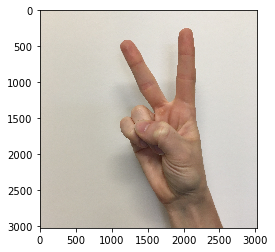

In [20]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

Visualize your ResNet-50

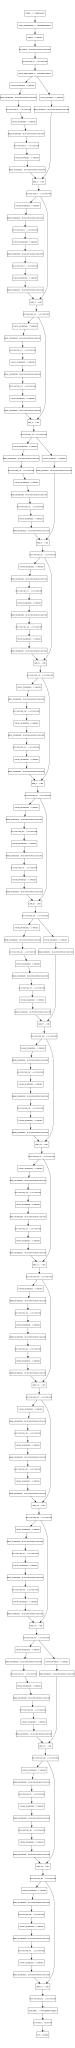

In [22]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### <font color='IndianRed'>References 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py